# XGBoost

## Importing

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight

### Evaluating Function

In [2]:
def evaluate(y_true, y_prob, titulo="Model"):
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)

    print(f"\n{titulo}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0,1], [0,1], '--')
    plt.title(f"ROC Curve - {titulo}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [ ]:
df = pd.read_csv("treated_data.csv")
df = df.drop(['types'], axis = 1)

X = df.drop(['isFraud', 'Unnamed: 0'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

## Basic


XGBoost - Basic
Accuracy:  0.9996
Precision:  0.9736
Recall:    0.7353
AUC-ROC:   0.9969


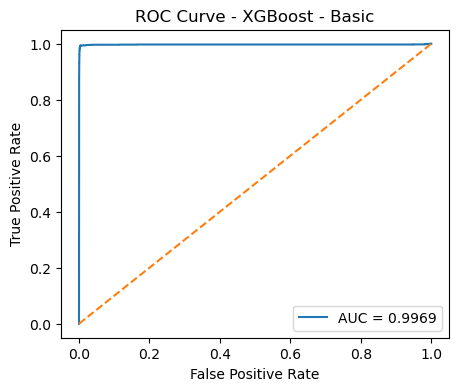

In [4]:
xgb_basic = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_basic.fit(X_train, y_train)

y_prob_basic = xgb_basic.predict_proba(X_test)[:, 1]

evaluate(y_test, y_prob_basic, "XGBoost - Basic")

## Undersample


XGBoost - Undersampling
Accuracy:  0.9959
Precision:  0.2382
Recall:    0.9947
AUC-ROC:   0.9995


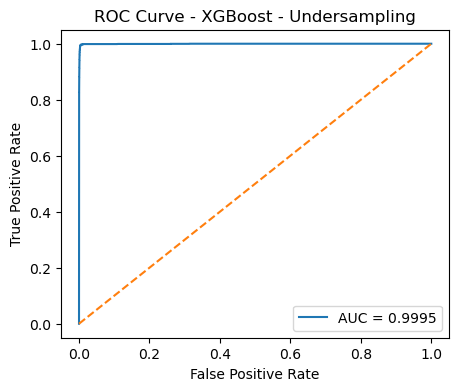

In [5]:
df_train = pd.concat([X_train, y_train], axis=1)

df0 = df_train[df_train['isFraud'] == 0]
df1 = df_train[df_train['isFraud'] == 1]

df0_under = resample(
    df0,
    replace=False,
    n_samples=len(df1) * 5, 
    random_state=42
)

df_train_bal = pd.concat([df0_under, df1])

X_train_bal = df_train_bal.drop(['isFraud'], axis=1)
y_train_bal = df_train_bal['isFraud']

xgb_under = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_under.fit(X_train_bal, y_train_bal)

y_prob_under = xgb_under.predict_proba(X_test)[:, 1]

evaluate(y_test, y_prob_under, "XGBoost - Undersampling")


## Weights

scale_pos_weight: 775.1333217148832

XGBoost - scale_pos_weight
Accuracy:  0.9973
Precision:  0.3233
Recall:    0.9947
AUC-ROC:   0.9996


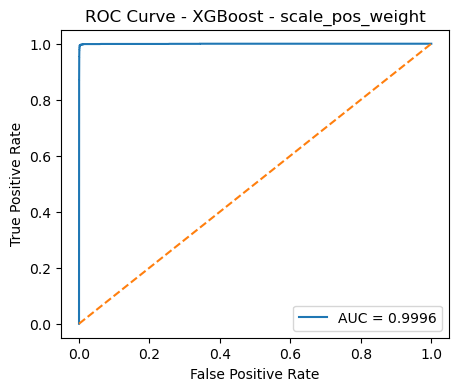

In [6]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

xgb_weighted = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

xgb_weighted.fit(X_train, y_train)

y_prob_weighted = xgb_weighted.predict_proba(X_test)[:, 1]

evaluate(y_test, y_prob_weighted, "XGBoost - scale_pos_weight")
